# Imports

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import math
import time
import ipywidgets as widgets

import cv2

import datetime
from zoneinfo import ZoneInfo

import pickle

from tqdm import tqdm

# Utils

In [2]:
def timestamp_to_datetime(timestamp):
    return datetime.datetime.fromtimestamp(timestamp, tz=ZoneInfo("Asia/Shanghai"))

# Dataset

In [3]:
order_df = pd.read_csv("Meituan-INFORMS-TSL-Research-Challenge/all_waybill_info_meituan_0322.csv")
# courier_df = pd.read_csv("Meituan-INFORMS-TSL-Research-Challenge/courier_wave_info_meituan.csv")
# assignment_order_df = pd.read_csv("Meituan-INFORMS-TSL-Research-Challenge/dispatch_waybill_meituan.csv")
# assignment_courier_df = pd.read_csv("Meituan-INFORMS-TSL-Research-Challenge/dispatch_rider_meituan.csv")

if os.path.exists("data/courier_timeline.csv"):
    courier_timeline = pd.read_csv("data/courier_timeline.csv")

In [4]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654343 entries, 0 to 654342
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   Unnamed: 0                  654343 non-null  int64
 1   dt                          654343 non-null  int64
 2   order_id                    654343 non-null  int64
 3   waybill_id                  654343 non-null  int64
 4   courier_id                  654343 non-null  int64
 5   da_id                       654343 non-null  int64
 6   is_courier_grabbed          654343 non-null  int64
 7   is_weekend                  654343 non-null  int64
 8   estimate_arrived_time       654343 non-null  int64
 9   is_prebook                  654343 non-null  int64
 10  poi_id                      654343 non-null  int64
 11  sender_lng                  654343 non-null  int64
 12  sender_lat                  654343 non-null  int64
 13  recipient_lng               654343 non-null 

In [5]:
courier_order_timeline = order_df[order_df["is_courier_grabbed"] == 1][["order_id", "courier_id", "dt", "da_id", "sender_lng", "sender_lat", "recipient_lng", "recipient_lat", "grab_lng", "grab_lat", "grab_time", "fetch_time", "arrive_time"]]
courier_order_timeline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568546 entries, 1 to 654342
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   order_id       568546 non-null  int64
 1   courier_id     568546 non-null  int64
 2   dt             568546 non-null  int64
 3   da_id          568546 non-null  int64
 4   sender_lng     568546 non-null  int64
 5   sender_lat     568546 non-null  int64
 6   recipient_lng  568546 non-null  int64
 7   recipient_lat  568546 non-null  int64
 8   grab_lng       568546 non-null  int64
 9   grab_lat       568546 non-null  int64
 10  grab_time      568546 non-null  int64
 11  fetch_time     568546 non-null  int64
 12  arrive_time    568546 non-null  int64
dtypes: int64(13)
memory usage: 60.7 MB


In [6]:
courier_timeline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705635 entries, 0 to 1705634
Data columns (total 8 columns):
 #   Column      Dtype
---  ------      -----
 0   order_id    int64
 1   courier_id  int64
 2   dt          int64
 3   da_id       int64
 4   lng         int64
 5   lat         int64
 6   time        int64
 7   event_type  int64
dtypes: int64(8)
memory usage: 104.1 MB


In [7]:
region_bounds = courier_timeline.groupby("da_id").agg(
    lat_min=("lat", "min"),
    lat_max=("lat", "max"),
    lng_min=("lng", "min"),
    lng_max=("lng", "max"),
).reset_index()

region_bounds

,da_id,lat_min,lat_max,lng_min,lng_max
0,0,45761739,46021132,174387310,174794674
1,1,45818207,46078385,174428193,174650464
2,2,45772291,45942500,174442646,174649182
3,3,45870077,45944307,174501771,174584227
4,4,45729124,45944991,174446881,174742491
5,5,45792123,46018159,174446693,174669627
6,6,46023787,46079853,174919725,174999535
7,7,45824995,45895075,174495452,174611425
8,8,45873312,45932546,174544185,174607451
9,9,45801945,45980095,174474198,174735894


# Data Segmentation

## Initial creation courier_timeline

In [7]:
courier_grab_timeline = courier_order_timeline[["order_id", "courier_id", "dt", "da_id", "grab_lng", "grab_lat", "grab_time"]].rename(columns={"grab_lng": "lng", "grab_lat": "lat", "grab_time": "time"})
courier_grab_timeline["event_type"] = 0

courier_fetch_timeline = courier_order_timeline[["order_id", "courier_id", "dt", "da_id", "sender_lng", "sender_lat", "fetch_time"]].rename(columns={"sender_lng": "lng", "sender_lat": "lat", "fetch_time": "time"})
courier_fetch_timeline["event_type"] = 1

courier_arrive_timeline = courier_order_timeline[["order_id", "courier_id", "dt", "da_id", "recipient_lng", "recipient_lat", "arrive_time"]].rename(columns={"recipient_lng": "lng", "recipient_lat": "lat", "arrive_time": "time"})
courier_arrive_timeline["event_type"] = 2

courier_timeline = pd.concat([courier_grab_timeline, courier_fetch_timeline, courier_arrive_timeline], axis=0, ignore_index=True)

# print(courier_timeline[courier_timeline["time"] == 0]) # Dropping 1 order (id=225004), as it is the only one with missing timestamp
courier_timeline = courier_timeline[courier_timeline["order_id"] != 225004]

courier_timeline = courier_timeline.sort_values(["time"])

courier_timeline

,order_id,courier_id,dt,da_id,lng,lat,time,event_type
45341,51383,247,20221017,0,174556864,45867384,1665936060,0
497263,503828,864,20221017,19,174561019,45895660,1665936061,0
350072,365519,1174,20221017,7,174562480,45865501,1665936111,0
88005,98318,1125,20221017,13,174570278,45907184,1665936118,0
224883,241817,4557,20221017,6,174941695,46042451,1665936120,0
...,...,...,...,...,...,...,...,...
1313320,191881,1139,20221024,9,174669342,45870288,1666629765,2
1569350,443596,1732,20221024,11,174551849,45903028,1666629835,2
1495708,373731,2033,20221024,9,174645449,45901584,1666629851,2
1651320,519348,325,20221024,1,174492819,45905498,1666629861,2


In [ ]:
courier_timeline.to_csv("courier_timeline.csv", index=False)

## Further Segmentation

In [3]:
courier_timeline.nunique()

order_id      568545
courier_id      4901
dt                 8
da_id             23
lng           148076
lat           139740
time          458583
event_type         3
dtype: int64

In [4]:
courier_timeline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705635 entries, 0 to 1705634
Data columns (total 8 columns):
 #   Column      Dtype
---  ------      -----
 0   order_id    int64
 1   courier_id  int64
 2   dt          int64
 3   da_id       int64
 4   lng         int64
 5   lat         int64
 6   time        int64
 7   event_type  int64
dtypes: int64(8)
memory usage: 104.1 MB


In [ ]:
print(timestamp_to_datetime(1666283330))

2022-10-21 00:28:50+08:00


In [7]:
courier_timeline["time"].min(), courier_timeline["time"].max()

(1665936060, 1666629978)

In [8]:
print(timestamp_to_datetime(1665936060))
print(timestamp_to_datetime(1666629978))

2022-10-17 00:01:00+08:00
2022-10-25 00:46:18+08:00


# Linear Interpolation of Courier Locations

In [22]:
def impute_courier(courier_id, dt):
    tmp = courier_timeline[(courier_timeline["courier_id"] == courier_id) & (courier_timeline["dt"] == dt)].copy().sort_values("time")[["courier_id", "dt", "lng", "lat", "time"]]

    lowest = tmp.iloc[0]["time"] + 10 - (tmp.iloc[0]["time"]%10)
    highest = tmp.iloc[-1]["time"] - 10 - (tmp.iloc[-1]["time"]%10)

    tmp2 = pd.DataFrame.from_dict({
        "courier_id": courier_id,
        "dt": dt,
        # "da_id": ,
        "lng": np.nan,
        "lat": np.nan,
        "time": list(range(lowest, highest, 10))
    })

    dense = pd.concat([tmp, tmp2], ignore_index=True)

    dense["datetime"] = pd.to_datetime(dense["time"], unit='s')

    # Make sure "time" is the index
    dense = dense.sort_values("datetime").set_index("datetime")

    # Interpolate along time axis
    dense[["lng", "lat"]] = dense[["lng", "lat"]].interpolate(method="time")

    filled = dense[dense["time"].isin(tmp2["time"])].reset_index()

    return filled

c_dt = courier_timeline[["courier_id", "dt"]].copy().drop_duplicates()

dts = courier_timeline["dt"].copy().drop_duplicates()

interpolated_data = {
    dt: {} for dt in dts.to_list()
}

for dt in interpolated_data:
    for c in tqdm(c_dt[c_dt["dt"] == dt]["courier_id"]):
        interpolated_data[dt][c] = impute_courier(c, dt)

100%|██████████| 3541/3541 [00:50<00:00, 70.32it/s]


In [24]:
for dt in tqdm(interpolated_data.keys()):
    with open(f"data/interpolated_data_{dt}.pkl", "wb") as f:
        pickle.dump(interpolated_data[dt], f)

100%|██████████| 8/8 [00:56<00:00,  7.03s/it]


In [ ]:
# combined_df = pd.concat([(pd.concat([interpolated_data[dt][c] for c in interpolated_data[dt].keys()], axis=0)) for dt in interpolated_data.keys()], axis=0)
combined_df = None
for dt in tqdm(interpolated_data.keys()):
    combined_df = pd.concat([interpolated_data[dt][c] for c in interpolated_data[dt].keys()], axis=0)
    # combined_df.to_csv(f"data_csv/combined_couriers_{dt}.csv")
    with open(f"data_csv/combined_couriers_{dt}.pkl", "wb") as f:
        pickle.dump(combined_df, f)
    # combined_df.to_csv(f"data_csv/combined_couriers_{dt}.csv")

In [24]:
with open("data_csv/combined_couriers_20221017.pkl", "rb") as f:
    tmp = pickle.load(f)
    tmp.to_csv(f"data_csv/combined_couriers_20221017.csv")

In [ ]:
import glob

files = glob.glob("data_csv/*.csv")

# write first file with header
first = True
with open("combined.csv", "w") as fout:
    for f in files:
        for i, chunk in tqdm(enumerate(pd.read_csv(f, index_col=0, chunksize=100_000))):
            # write header only once
            chunk.to_csv(fout, index=False, header=first)
            first = False

# Plotting Courier Locations

In [8]:
with open("data/intervaled_courier_timeline.pkl", "rb") as f:
    intervaled_courier_timeline: pd.DataFrame = pickle.load(f)

In [9]:
timestamp_min = intervaled_courier_timeline["time"].min()
timestamp_max = intervaled_courier_timeline["time"].max()

In [10]:
intervaled_courier_timeline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92225664 entries, 0 to 126
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   datetime    datetime64[ns]
 1   courier_id  int64         
 2   dt          int64         
 3   lng         float64       
 4   lat         float64       
 5   time        int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 4.8 GB


In [12]:
def get_snapshot(timestamp: int):
    if (timestamp % 10) != 0:
        raise Exception("Timestamp not recorded")
    
    orders = {
        "grabbed": courier_order_timeline[(courier_order_timeline["grab_time"] <= timestamp) & (courier_order_timeline["fetch_time"] >= timestamp) & (courier_order_timeline["arrive_time"] >= timestamp)],
        "fetched": courier_order_timeline[(courier_order_timeline["grab_time"] <= timestamp) & (courier_order_timeline["fetch_time"] <= timestamp) & (courier_order_timeline["arrive_time"] >= timestamp)],
    }

    known_couriers = intervaled_courier_timeline[intervaled_courier_timeline["time"] == timestamp].copy()

    known_couriers = known_couriers.join(
        orders["grabbed"]["courier_id"].value_counts().rename("orders_grabbed"),
        on="courier_id"
    ).fillna({"orders_grabbed": 0}).astype({"orders_grabbed": int})

    known_couriers = known_couriers.join(
        orders["fetched"]["courier_id"].value_counts().rename("orders_fetched"),
        on="courier_id"
    ).fillna({"orders_fetched": 0}).astype({"orders_fetched": int})

    known_couriers["status"] = 0 # idle
    known_couriers.loc[(known_couriers["orders_grabbed"] > 0) & (known_couriers["orders_fetched"] == 0), "status"] = 1
    known_couriers.loc[(known_couriers["orders_grabbed"] == 0) & (known_couriers["orders_fetched"] > 0), "status"] = 2
    known_couriers.loc[(known_couriers["orders_grabbed"] > 0) & (known_couriers["orders_fetched"] > 0), "status"] = 3

    # mask_idle = ~(known_couriers["courier_id"].isin(orders["grabbed"]["courier_id"])) & ~(known_couriers["courier_id"].isin(orders["fetched"]["courier_id"]))
    # known_couriers.loc[mask_idle, "status"] = 0 # idle
    # mask_grab = (known_couriers["courier_id"].isin(orders["grabbed"]["courier_id"])) & ~(known_couriers["courier_id"].isin(orders["fetched"]["courier_id"]))
    # known_couriers.loc[mask_grab, "status"] = 1 # heading for pickup
    # mask_pickup = ~(known_couriers["courier_id"].isin(orders["grabbed"]["courier_id"])) & (known_couriers["courier_id"].isin(orders["fetched"]["courier_id"]))
    # known_couriers.loc[mask_pickup, "status"] = 2 # heading for delivery
    # mask_both = (known_couriers["courier_id"].isin(orders["grabbed"]["courier_id"])) & (known_couriers["courier_id"].isin(orders["fetched"]["courier_id"]))
    # known_couriers.loc[mask_both, "status"] = 3 # multi-orders of different statuses

    return orders, known_couriers

lat_bounds = courier_timeline["lat"].min(), courier_timeline["lat"].max()
lng_bounds = courier_timeline["lng"].min(), courier_timeline["lng"].max()
lng_range = (lng_bounds[1]-lng_bounds[0])
lat_range = (lat_bounds[1]-lat_bounds[0])

def plot_snapshot(orders: pd.DataFrame, couriers: pd.DataFrame, region_id: int):
    couriers = couriers.copy()
    orders_grabbed = orders["grabbed"].copy()
    orders_fetched = orders["fetched"].copy()

    couriers["lng_norm"] = (couriers["lng"] - lng_bounds[0]) / lng_range
    couriers["lat_norm"] = (couriers["lat"] - lat_bounds[0]) / lat_range

    orders_grabbed["sender_lng_norm"] = (orders_grabbed["sender_lng"] - lng_bounds[0]) / lng_range
    orders_grabbed["sender_lat_norm"] = (orders_grabbed["sender_lat"] - lat_bounds[0]) / lat_range
    orders_grabbed["recipient_lng_norm"] = (orders_grabbed["recipient_lng"] - lng_bounds[0]) / lng_range
    orders_grabbed["recipient_lat_norm"] = (orders_grabbed["recipient_lat"] - lat_bounds[0]) / lat_range

    orders_fetched["sender_lng_norm"] = (orders_fetched["sender_lng"] - lng_bounds[0]) / lng_range
    orders_fetched["sender_lat_norm"] = (orders_fetched["sender_lat"] - lat_bounds[0]) / lat_range
    orders_fetched["recipient_lng_norm"] = (orders_fetched["recipient_lng"] - lng_bounds[0]) / lng_range
    orders_fetched["recipient_lat_norm"] = (orders_fetched["recipient_lat"] - lat_bounds[0]) / lat_range

    region_plot_size = 8
    plt.figure(figsize=(region_plot_size,region_plot_size))

    current_region_bounds = region_bounds[region_bounds["da_id"] == region_id].iloc[0]
    current_region_bounds["lng_min_norm"] = (current_region_bounds["lng_min"]-lng_bounds[0]) / lng_range
    current_region_bounds["lng_max_norm"] = (current_region_bounds["lng_max"]-lng_bounds[0]) / lng_range
    current_region_bounds["lat_min_norm"] = (current_region_bounds["lat_min"]-lat_bounds[0]) / lat_range
    current_region_bounds["lat_max_norm"] = (current_region_bounds["lat_max"]-lat_bounds[0]) / lat_range

    current_couriers = couriers[
        (couriers["lng"] >= current_region_bounds["lng_min"]) &
        (couriers["lng"] <= current_region_bounds["lng_max"]) &
        (couriers["lat"] >= current_region_bounds["lat_min"]) &
        (couriers["lat"] <= current_region_bounds["lat_max"])
    ]
    current_orders_grabbed = orders_grabbed[orders_grabbed["courier_id"].isin(current_couriers["courier_id"])]
    current_orders_fetched = orders_fetched[orders_fetched["courier_id"].isin(current_couriers["courier_id"])]

    plt.xlim((current_region_bounds["lng_min_norm"]-0.1, current_region_bounds["lng_max_norm"]+0.1))
    plt.ylim((current_region_bounds["lat_min_norm"]-0.1, current_region_bounds["lat_max_norm"]+0.1))

    plt.scatter(current_couriers[current_couriers["status"] == 0]["lng_norm"], current_couriers[current_couriers["status"] == 0]["lat_norm"], c="b", alpha=.2);
    plt.scatter(current_couriers[current_couriers["status"] == 1]["lng_norm"], current_couriers[current_couriers["status"] == 1]["lat_norm"], c="g");
    plt.scatter(current_couriers[current_couriers["status"] == 2]["lng_norm"], current_couriers[current_couriers["status"] == 2]["lat_norm"], c="r");
    plt.scatter(current_couriers[current_couriers["status"] == 3]["lng_norm"], current_couriers[current_couriers["status"] == 3]["lat_norm"], c="y");

    plt.scatter(current_orders_grabbed["sender_lng_norm"], current_orders_grabbed["sender_lat_norm"], marker="s", c="orange");
    plt.scatter(current_orders_grabbed["recipient_lng_norm"], current_orders_grabbed["recipient_lat_norm"], marker="x", c="orange");

    plt.scatter(current_orders_fetched["sender_lng_norm"], current_orders_fetched["sender_lat_norm"], marker="s", c="orange");
    plt.scatter(current_orders_fetched["recipient_lng_norm"], current_orders_fetched["recipient_lat_norm"], marker="x", c="orange");

    plt.title(f"Region {current_region_bounds["da_id"]}");

In [13]:
orders, couriers = get_snapshot(1666027350)

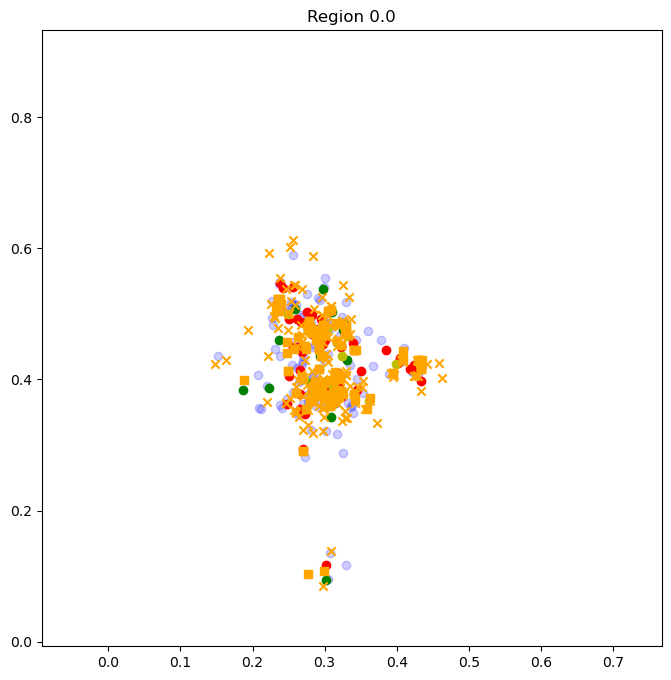

In [14]:
plot_snapshot(orders, couriers, 0)

In [20]:
def plot_at_time(t):
    timestamp = timestamp_min + 60 * t
    # timestamp = (timestamp_max - 1440*60) + 60 * t
    
    orders, couriers = get_snapshot(timestamp)
    plot_snapshot(orders, couriers, 2)

    print(timestamp_to_datetime(timestamp))

widgets.interact(plot_at_time, t=(0, 1440, 1));

interactive(children=(IntSlider(value=720, description='t', max=1440), Output()), _dom_classes=('widget-intera…

---

In [23]:
def compile_window(timestamp_min, timestamp_max, region_id):
    os.makedirs("compile_video_frames", exist_ok=True)

    timestamp_min -= timestamp_min%10
    for timestamp in tqdm(range(timestamp_min, timestamp_max, 10)):        
        orders, couriers = get_snapshot(timestamp)
        plot_snapshot(orders, couriers, region_id)
        plt.savefig(f"compile_video_frames/frame_{timestamp}.jpg");
        plt.close(); 

    frame = cv2.imread(f"compile_video_frames/frame_{timestamp_min}.jpg")

    # max_size = 1920  # e.g. 1080p width
    # scale = max_size / max(frame.shape[1], frame.shape[0])
    # frame = cv2.resize(frame, None, fx=scale, fy=scale)

    h, w, _ = frame.shape
    fps = 12
    # out = cv2.VideoWriter("simulation.avi", cv2.VideoWriter_fourcc(*"XVID"), 10, (w, h))
    out = cv2.VideoWriter(
        "output.mp4",
        cv2.VideoWriter_fourcc(*"mp4v"),  # or "avc1"
        fps,
        (w,h)
    )

    for timestamp in tqdm(range(timestamp_min, timestamp_max, 10)):
        img = cv2.imread(f"compile_video_frames/frame_{timestamp}.jpg")
        out.write(img)

    out.release()

In [24]:
compile_window(timestamp_min, timestamp_min + 60*60, 2)

100%|██████████| 360/360 [00:01<00:00, 199.51it/s]
